In [21]:
pip install seaborn


     ------------------------------------ 294.6/294.6 kB 911.4 kB/s eta 0:00:00



[notice] A new release of pip available: 22.3 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [22]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Reshape, Dropout, GRU
from tensorflow.keras.layers import BatchNormalization
from tqdm import tqdm
from tensorflow.keras.layers import Input, Dense, Concatenate, Reshape, LSTM, MultiHeadAttention
from tensorflow.keras.layers import Input, Dense, Concatenate, Reshape, LSTM, MultiHeadAttention
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
import seaborn as sns


In [13]:
import os
import tensorflow as tf

os.environ["CUDA_VISIBLE_DEVICES"] = "6"  # Replace "0" with the index of the desired GPU

# Check if GPU is available
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the specified GPU
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

    # Check GPU information
    physical_devices = tf.config.experimental.list_physical_devices('GPU')
    print(f"Using GPU: {tf.test.gpu_device_name()}")

The dataset_gen function helps to perfrom data preprocessing on the tech content and saperates training and test set

In [14]:
scaler = MinMaxScaler()


def dataset_gen(data_full_df):
    
    columns_to_normalize = ['Open','High', 'Low', 'Close', 'Volume']
    data_full_df[columns_to_normalize] = scaler.fit_transform(data_full_df[columns_to_normalize])
    data_full_df = data_full_df.drop(columns=['Adj Close'], axis=1)
    print(data_full_df.head(5))
    data_full_np = data_full_df.values
    
    x_train = []
    y_train = []
    x_test = []
    y_test = []

    last_index = 0
    for i in tqdm(range(0, data_full_np.shape[0] - 300)):
        x_train.append(data_full_np[i:i + 200])
        y_train.append(data_full_np[i + 200:i + 220])
        last_index= i
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    
    x_test.append( data_full_np[last_index+10: last_index+210])
    y_test.append(data_full_np[last_index+210: last_index+230])
    x_test.append(data_full_np[last_index+40: last_index+240])
    y_test.append(data_full_np[last_index+240: last_index+260])
    x_test.append(data_full_np[last_index+60: last_index+260])
    y_test.append(data_full_np[last_index+260: last_index+280])
    
    x_test = np.array(x_test)
    y_test = np.array(y_test)
    
    print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
    return x_train, y_train, x_test, y_test

Reads Amazon CSV file and passes it to dataset generation function

In [15]:
AMZN_df = pd.read_csv('AMZN.csv')

print(AMZN_df.info())
print(AMZN_df.describe())

AMZN_x_train, AMZN_y_train, AMZN_x_test, AMZN_y_test = dataset_gen(AMZN_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6022 entries, 0 to 6021
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       6022 non-null   object 
 1   Open       6022 non-null   float64
 2   High       6022 non-null   float64
 3   Low        6022 non-null   float64
 4   Close      6022 non-null   float64
 5   Adj Close  6022 non-null   float64
 6   Volume     6022 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 329.5+ KB
None
              Open         High          Low        Close    Adj Close  \
count  6022.000000  6022.000000  6022.000000  6022.000000  6022.000000   
mean     37.637044    38.085257    37.150524    37.627145    37.627145   
std      51.325787    51.931140    50.660187    51.295879    51.295879   
min       0.295500     0.305000     0.275500     0.298500     0.298500   
25%       2.265625     2.300000     2.226125     2.263875     2.263875   
50%      10.167750   

100%|██████████| 5722/5722 [00:00<00:00, 1429070.35it/s]

(5722, 200, 6) (5722, 20, 6) (3, 200, 6) (3, 20, 6)


Reads S&P 500 CSV file and passes it to dataset generation function

In [16]:
SPX_df = df = pd.read_csv('SPX.csv')

print(SPX_df.info())
print(SPX_df.describe())

SPX_x_train, SPX_y_train, SPX_x_test, SPX_y_test = dataset_gen(SPX_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6022 entries, 0 to 6021
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       6022 non-null   object 
 1   Open       6022 non-null   float64
 2   High       6022 non-null   float64
 3   Low        6022 non-null   float64
 4   Close      6022 non-null   float64
 5   Adj Close  6022 non-null   float64
 6   Volume     6022 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 329.5+ KB
None
              Open         High          Low        Close    Adj Close  \
count  6022.000000  6022.000000  6022.000000  6022.000000  6022.000000   
mean   1966.479966  1978.106107  1953.972933  1966.739870  1966.739870   
std    1053.525035  1058.846003  1047.942096  1053.737482  1053.737482   
min     679.280029   695.270020   666.789978   676.530029   676.530029   
25%    1191.147522  1198.464966  1183.897553  1191.300018  1191.300018   
50%    1456.320007  1

  0%|          | 0/5722 [00:00<?, ?it/s]

100%|██████████| 5722/5722 [00:00<00:00, 1905654.08it/s]

(5722, 200, 6) (5722, 20, 6) (3, 200, 6) (3, 20, 6)


Reads Duke Energy CSV file and passes it to dataset generation function

In [17]:
DUK_df = df = pd.read_csv('DUK.csv')

print(DUK_df.info())
print(DUK_df.describe())

DUK_x_train, DUK_y_train, DUK_x_test, DUK_y_test = dataset_gen(DUK_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6022 entries, 0 to 6021
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       6022 non-null   object 
 1   Open       6022 non-null   float64
 2   High       6022 non-null   float64
 3   Low        6022 non-null   float64
 4   Close      6022 non-null   float64
 5   Adj Close  6022 non-null   float64
 6   Volume     6022 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 329.5+ KB
None
              Open         High          Low        Close    Adj Close  \
count  6022.000000  6022.000000  6022.000000  6022.000000  6022.000000   
mean     67.037377    67.623590    66.408560    67.033302    44.574863   
std      20.109515    20.235137    19.990161    20.115417    26.139180   
min      21.477455    21.860983    21.285692    21.477455     8.033481   
25%      51.130989    51.608761    50.695164    51.183289    23.198706   
50%      66.946358   

100%|██████████| 5722/5722 [00:00<00:00, 1905654.08it/s]

(5722, 200, 6) (5722, 20, 6) (3, 200, 6) (3, 20, 6)


Reads Apple CSV file and passes it to dataset generation function

In [18]:
AAPL_df = df = pd.read_csv('AAPL.csv')

print(AAPL_df.info())
print(AAPL_df.describe())

AAPL_x_train, AAPL_y_train, AAPL_x_test, AAPL_y_test = dataset_gen(AAPL_df)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6022 entries, 0 to 6021
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       6022 non-null   object 
 1   Open       6022 non-null   float64
 2   High       6022 non-null   float64
 3   Low        6022 non-null   float64
 4   Close      6022 non-null   float64
 5   Adj Close  6022 non-null   float64
 6   Volume     6022 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 329.5+ KB
None
              Open         High          Low        Close    Adj Close  \
count  6022.000000  6022.000000  6022.000000  6022.000000  6022.000000   
mean     35.440285    35.829528    35.067292    35.464683    34.154099   
std      50.442579    51.011087    49.919386    50.491567    50.278543   
min       0.231964     0.235536     0.227143     0.234286     0.198599   
25%       2.152947     2.188393     2.122500     2.149196     1.821830   
50%      14.394643   

100%|██████████| 5722/5722 [00:00<00:00, 1143446.92it/s]

(5722, 200, 6) (5722, 20, 6) (3, 200, 6) (3, 20, 6)


Reads the dataset for each company stock with date as a index column and concatinates each dataset into one.

In [43]:
DUK_df = pd.read_csv('DUK.csv', index_col='Date', parse_dates=True)
AAPL_df = pd.read_csv('AAPL.csv', index_col='Date', parse_dates=True)
AMZN_df = pd.read_csv('AMZN.csv', index_col='Date', parse_dates=True)

# Concatenate the DataFrames along columns
combined_df = pd.concat([DUK_df, AAPL_df, AMZN_df], axis=1)

# Select 'Adj Close' columns
combined_df_close = combined_df[['Close']]
# Calculate daily returns
combined_df_returns = combined_df_close.pct_change()

combined_df_returns.columns = ['DUK', 'AAPL', 'AMZN']
combined_df_returns.head()

,DUK,AAPL,AMZN
Date,,,
2000-01-03,NaN,NaN,NaN
2000-01-04,0.015544,-0.084310,-0.083217
2000-01-05,0.040816,0.014633,-0.148741
2000-01-06,0.026961,-0.086538,-0.060036
2000-01-07,0.026253,0.047369,0.061010


This plot shows correaltion of close stock values of apple with itself. We can clearly see from the graph that correlation is always lenear and positive when compared with itself

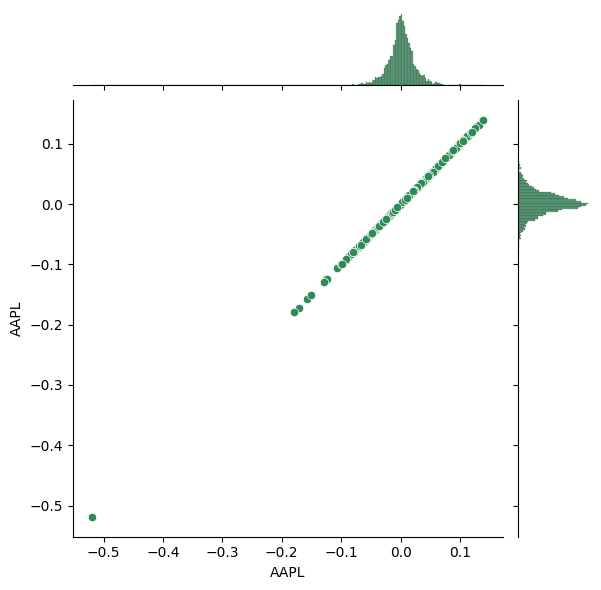

In [45]:
sns.jointplot(x='AAPL', y='AAPL', data=combined_df_returns, kind='scatter', color='seagreen')


This plot shows correaltion of a company's closing price with other company's closing price

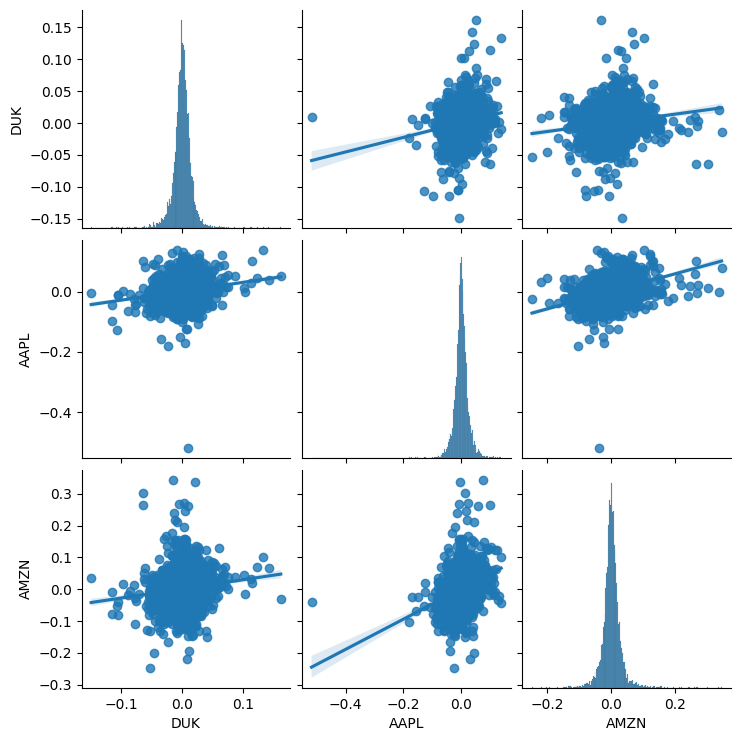

In [46]:
sns.pairplot(combined_df_returns, kind='reg')

This shows valued correaltion of a company's closing price with other company's closing price. We can see that correlation between Apple and Amazon price is more positive. Meaning that there is a chance that if Apple stock changes there might/can be changes to Amazon closing price as well. The factor that causes this might be anything.

Text(0.5, 1.0, 'Correlation of stock closing price')

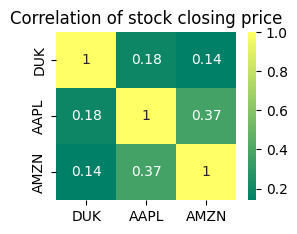

In [48]:
plt.subplot(2, 2, 2)
sns.heatmap(combined_df_returns.corr(), annot=True, cmap='summer')
plt.title('Correlation of stock closing price')